# Exploring Movie Comments with Naive Bayes

I analyzed movie reviews in an attempt to determine whether movies are good or bad. I downloaded a dataset of movie reviews from the Rotten Tomatoes website which is available in the file "reviews.csv".

The goal of this project is to build a predictor of freshness from movie quotes. Since the model is predicting results based on text data, I decided to use a Naive Bayes model. Naive Bayes has proven to be extremely effective at handling text data and, thus, is a good fit for this project.

The end result is a Naive Bayes classifier to determine whether a movie is Good (Fresh) or Bad (Rotten) based on the contents of the reviews given to the movie.

In [2]:
# Import Data
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from operator import itemgetter

### Import Sklearn Packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
# Load Data
reviews = pd.read_csv('reviews.csv')

### Clean Reivew DataFrame
reviews = reviews[~reviews.quote.isnull()] # remove rows that contain no string in the quote variable
reviews = reviews[reviews.fresh != 'none'] # removes rows that have no 'string' in the fresh variable
reviews = reviews[reviews.quote.str.len() > 0] # removes rows that have an empty string

## Some Exploration!

Before building the model, I wanted to explore the dataset to get a better understanding of what I was working with. I looked at the information available to me along with the counts and distributions of different features.

In [5]:
### Features of Dataset
print reviews.columns
print reviews.head()

Index([u'critic', u'fresh', u'imdb', u'link', u'publication', u'quote',
       u'review_date', u'rtid', u'title'],
      dtype='object')
               critic  fresh    imdb  \
0         Derek Adams  fresh  114709   
1     Richard Corliss  fresh  114709   
2         David Ansen  fresh  114709   
3       Leonard Klady  fresh  114709   
4  Jonathan Rosenbaum  fresh  114709   

                                                link     publication  \
0  http://www.timeout.com/film/reviews/87745/toy-...        Time Out   
1  http://www.time.com/time/magazine/article/0,91...   TIME Magazine   
2                  http://www.newsweek.com/id/104199        Newsweek   
3  http://www.variety.com/review/VE1117941294.htm...         Variety   
4  http://onfilm.chicagoreader.com/movies/capsule...  Chicago Reader   

                                               quote          review_date  \
0  So ingenious in concept, design and execution ...  2009-10-04 00:00:00   
1                  The year's most 

In [13]:
### Looking at different Features of Dataset
print "Number of reviews: {}".format(len(reviews))
print "Number of unique reviews: {}".format(len(reviews['quote'].unique()))
print "Number of unique reviewers: {}".format(len(reviews['critic'].unique()))
print "Number of unique movies in the reviews dataset: {}".format(len(reviews['imdb'].unique()))
print "Number of different publications that have reviews in the reviews dataset: {}".format(len(reviews['publication'].unique()))

Number of reviews: 13419
Number of unique reviews: 12814
Number of unique reviewers: 541
Number of unique movies in the reviews dataset: 1720
Number of different publications that have reviews in the reviews dataset: 64


Let's take a look at the contributions of each reviewer.

In [7]:
def initialize_figure():
    """
    initialize_figure
    -----------------
    This function intizilatized figures and removes the top and right axes.
    """
    fig, ax = plt.subplots(figsize=(8,6))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    return fig, ax

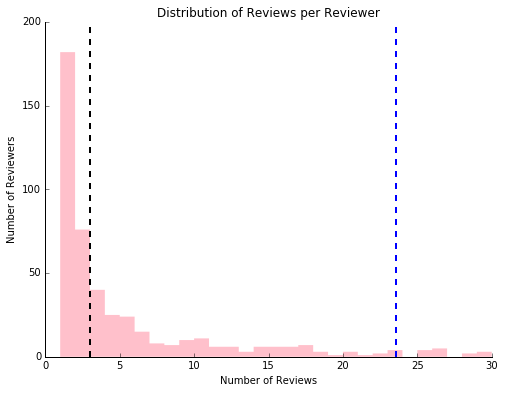

In [14]:
### Gather number of reviews per critic
number_of_reviews = list()
for g in reviews.groupby('critic'):
    number_of_reviews.append(len(g[1]))
    
### Initialize and plot Histogram
fig, ax = initialize_figure()
plt.hist(number_of_reviews,bins=range(0, 31, 1),color='pink', edgecolor = "none", histtype='stepfilled')
plt.axvline(np.mean(number_of_reviews), color='b', linestyle='dashed', linewidth=2)
plt.axvline(np.median(number_of_reviews), color='k', linestyle='dashed', linewidth=2)
### Set Labels
plt.ylabel('Number of Reviewers')
plt.xlabel('Number of Reviews')
plt.title('Distribution of Reviews per Reviewer')
plt.show()

Most reviews are written by reviewers who write less than 4 reviews.

---

## Building the Model

I built a predictive model for movie reviews using a Naive Bayes Multinomial algorithm. I used a custom Naive Bayes Multinomial class to build the model. Then, I create a model using SciKit Learns toolkit for Machine Learning. In order to compare performance, I calculated accuracy on predicting both training and test data and visualized the confusion matrix for each model. The confusion matrix would be able to tell us which cases were confusing the model.

Before building the model, I created a bag-of-words dataset for the review data

In [17]:
def make_xy(reviews, vectorizer=None):
    """
    make_xy
    -------
    Builds a bag-of-words data set for the review data

    Parameters
    ----------
    reviews : Pandas DataFrame
    
    vectorizer : CountVectorizer object (optional)
        A CountVectorizer object to use. If None,
        then create and fit a new CountVectorizer.
        Otherwise, re-fit the provided CountVectorizer
        using the reviews data
    
    Returns
    -------
    X : numpy array (dims: nreview, nwords)
        Bag-of-words representation for each review.
    Y : numpy array (dims: nreview)
        1/0 array. 1 = fresh review, 0 = rotten review

    Examples
    --------
    X, Y = make_xy(reviews)
    """
    if vectorizer == None:   
        vectorizer = CountVectorizer(min_df=0)
    vectorizer.fit(reviews.quote)
    X = np.array(vectorizer.transform(reviews.quote).todense())
    Y = np.array(reviews.fresh.replace({'fresh':1.0,'rotten':0.0}))
    return X, Y

In [18]:
X, Y = make_xy(reviews)

The data is then split into training and testing data.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.33, random_state=0)

Next, a custom Naive Bayes Multinomial class was used to build the model.

In [20]:
class Naive_Bayes_Multinomial:
    """
    Naive_Bayes_Multinomial
    ---
    Constructs a Naive Bayes Multinomial object from training and testing data.
    
    Parameters
    ----------
    X: Matrix capturing the distribution of features
    
    y: Array capture the true values of y
    
    training: Matrix containing the distribution of features, the final column contains the class values
    
    alpha: Additive smoothing parameter 
    
    Examples
    --------
    fitted_model = Naive_Bayes_Multinomial(X,y,training,alpha=0.005)
    """
    def __init__(self, X, y, training, alpha=0.01):
        self.X = X
        self.truths = y
        self.num_of_class = len(np.unique(y))
        self.data = training
        self.count_sample = X.shape[0]
        self.alpha = alpha
        self.clp, self.flp = self.__fitter()
        self.predictions = self.__predict()
    
    def __separate_by_category(self):
        """
        separate_by_category
        --------------------
        Separated each training sample into n groups (n=number of classes)
        
        Returns
        -------
        separated: dictionary of lists of training data points with each class set as the key
        """
        separated = dict()
        for i in range(len(self.data)):
            vector = self.data[i,:]
            if vector[-1] not in separated:
                separated[vector[-1]] = []
            separated[vector[-1]].append(vector[:-1])
        return separated

    def __class_log_prior (self,seperated):
        """
        class_log_prior
        ---------------
        calculates the base probability for each class
        
        Returns
        -------
        List of floats
        """
        return [np.log(len(i) / float(self.count_sample)) for i in seperated.values()]

    def __counter (self,separated):
        """
        counter
        -------
        calculates the distribution of features by each class
        
        Returns
        -------
        Array of counts
        """
        return np.array([np.array(i).sum(axis=0) for i in separated.values()]) + self.alpha

    def __fitter(self):
        """
        fitter
        ------
        Fits a Naive Bayes Multinomial to a training set.
        
        Returns
        -------
        clp (class log priors): a list of default class probabilities (P(c))
        
        flp (feature log priors): a list of probability of a feature given a class (P(f|c))
        """
        seperated = self.__separate_by_category()
        clp = self.__class_log_prior(seperated)
        count = self.__counter(seperated)
        flp = np.log10(count / count.sum(axis=1)[np.newaxis].T)
        return clp, flp

    def __predict_log_proba(self):
        """
        predict_log_proba
        -----------------
        calculates the log probabilities of each class for the testing data
        
        Return
        ------
        An array of log probabilties
        """
        return [(self.flp * x).sum(axis=1) + self.clp for x in self.X]

    def __predict(self):
        """
        predict
        -------
        predicts the class of a test case based on the log probabilties
        
        Return
        ------
        A list of class predictions
        """
        log_proba = self.__predict_log_proba()
        return np.argmax(log_proba, axis=1)

    def get_accuracy(self):
        """
        get_accuracy
        ------------
        calculates accuracy of model
        
        Return
        ------
        float
        """
        correct = 0
        for x in range(len(self.truths)):
            if self.truths[x] == self.predictions[x]:
                correct += 1
        return correct/float(len(self.truths))
    
    def get_confusion_matrix(self):
        """
        get_confusion_matrix
        --------------------
        generates a confusion matrix for the model
        
        Return
        ------
        a numpy matrix
        """
        confusion_matrix = np.zeros((self.num_of_class,self.num_of_class))
        for x in range(len(self.truths)):
            confusion_matrix[int(self.truths[x])][int(self.predictions[x])] += 1
        return confusion_matrix

In [21]:
def plot_confusion_matrix(cm, classes, normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    plot_confusion_matrix
    ---------------------
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Parameters
    ----------
    cm : Numpy Matrix
    
    classes : a list of classes
    
    normalizae: Bool
    
    title: str that titles

    Examples
    --------
    X, Y = make_xy(reviews)
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Training

Accuracy: 0.954616240267

Confusion matrix, without normalization
[[ 3103.   271.]
 [  137.  5479.]]


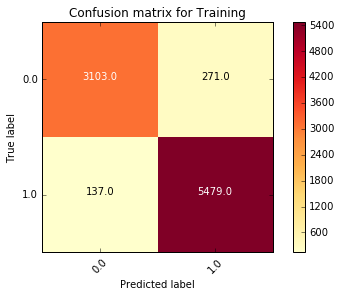

Testing

Accuracy: 0.733122601039

Confusion matrix, without normalization
[[  910.   746.]
 [  436.  2337.]]


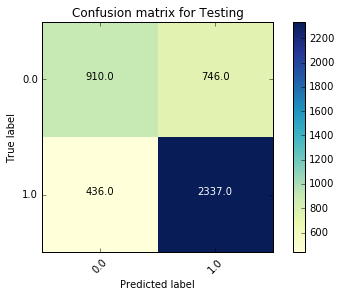

In [23]:
training_data = data = np.hstack((X_train,y_train.reshape(len(y_train),1)))
classes = np.unique(y_train)

mnd = Naive_Bayes_Multinomial(X_train,y_train,training_data,0.01)
print "Training\n"
print "Accuracy: {}\n".format(mnd.get_accuracy())
cm = mnd.get_confusion_matrix()
plot_confusion_matrix(cm,classes,title='Confusion matrix for Training',cmap=plt.cm.YlOrRd)
plt.show()

mnd = Naive_Bayes_Multinomial(X_test,y_test,training_data,0.01)
print "Testing\n"
print "Accuracy: {}\n".format(mnd.get_accuracy())
cm = mnd.get_confusion_matrix()
plot_confusion_matrix(cm,classes,title='Confusion matrix for Testing',cmap=plt.cm.YlGnBu)
plt.show()

Finally, the model's accuracy was compared to the accuracy of a model built using sklearns MultinomialNB class.

Training Accuracy for sklearn model: 0.925139043382
Confusion matrix, without normalization
[[2864  510]
 [ 163 5453]]


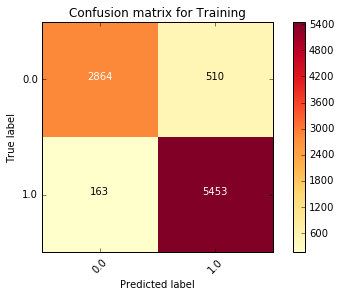

Testing Accuracy for sklearn model: 0.776473244525
Confusion matrix, without normalization
[[ 968  688]
 [ 302 2471]]


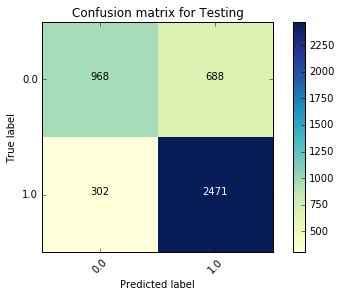

In [24]:
clf = MultinomialNB()
fitted_model = clf.fit(X_train,y_train)

y_pred = fitted_model.predict(X_train)
cm = confusion_matrix(y_train,y_pred)
print "Training Accuracy for sklearn model: {}".format(fitted_model.score(X_train, y_train))
plot_confusion_matrix(cm,classes,title='Confusion matrix for Training',cmap=plt.cm.YlOrRd)
plt.show()

y_pred = fitted_model.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
print "Testing Accuracy for sklearn model: {}".format(fitted_model.score(X_test, y_test))
plot_confusion_matrix(cm,classes,title='Confusion matrix for Testing',cmap=plt.cm.YlGnBu)
plt.show()

The custom Naive Bayes object seems to be overfitting the data as demonstrated by its higher accuracy on the training data and the lower accuracy on the testing data. However, the accuarcies of both the training and testing are comparable. The confusion matrices show the the model is likely to make a Type I Error classifying a "Rotten" case as "Fresh".

---

## Exploring the Errors

To better understand what is happening, I will look at the cases the model is getting wrong.

In [25]:
#Your code here
wrong = {0:list(),1:list()}
predict = fitted_model.predict(X_test)
for i in range(len(predict)):
    if predict[i] != y_test[i]:
        wrong[y_test[i]].append(i)
print "Rotten"
for w in wrong[0][0:5]:
    print reviews.quote[w]
print "\nFresh"
for w in wrong[1][0:5]:
    print reviews.quote[w]

Rotten
The year's most inventive comedy.
The film sports a provocative and appealing story that's every bit the equal of this technical achievement.
Children will enjoy a new take on the irresistible idea of toys coming to life. Adults will marvel at a witty script and utterly brilliant anthropomorphism.
Disney's first computer-made animated feature is a 3-D eye popper.
Walter Matthau and Jack Lemmon are awfully good at this sort of thing.

Fresh
Just don't expect their bickering to be on the level of Neil Simon, and you won't be disappointed.
Sudden Death is one of the best action thrillers of 1995. It's also the film Jean-Claude Van Damme has been building up to for 10 years.
Supercharged with spectacular, thundering, brain-numbing fun.
What it finally adds up to is a huge mixed bag of waxworks and daring, a film that is furiously ambitious even when it goes flat, and startling even when it settles for eerie, movie-of-the-week mimicry.
The sensibility may be a bit off, but there is m

It appears that the model seems to be misclassifying cases which quotes have heavy sarcasism or rely on some semantic meaning not embedded in the frequency of the words. How to automatically detect sarcasm is still unclear and an area of active research.

---

## Closing Remarks

Naive Bayes performed well in predicting whether or not a movie was "Fresh"/"Rotten" using quotes. Our testing accuracies float around 75%. The confusion matrix seems to suggest that the model is more likely to make a Type I Error classifying a "Rotten" case as "Fresh".. When we look closer at the data, the model struggles to capture sarcastic reviews. A future model should make an attempt add sarcasism as a feature for the future.